In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc(i, fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
import mnist
import tensorflow as tf
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# number of classes trained on
num_classes = 2
num_adversarial = 10 #how many adversarial examples should be generated (if any) per iteration
num_adversarial_train = 5 # how many iterations for the adversarial

/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Training Accuracy in iteration  0 : 0.307692
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 0.966667
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.998109
Final Accuracy on unexpected data 199 : 0.364109


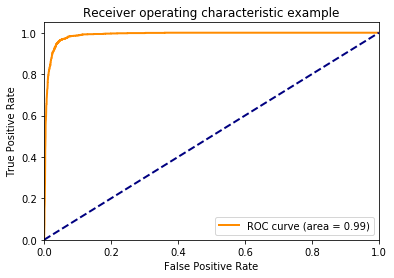

In [4]:
tf.reset_default_graph()
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, num_classes)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withContingency, learning_rate, mnistCont, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.413793
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.999054
Final Accuracy on unexpected data 199 : 0.689664


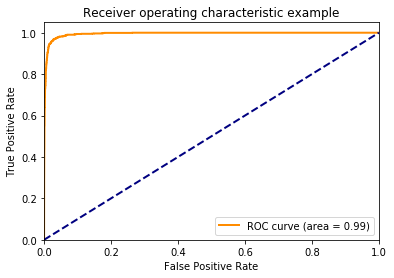

In [5]:
tf.reset_default_graph()
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, num_classes)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withoutContingency, learning_rate, mnistCont, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.454545
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes 199 : 0.998582
Final Accuracy on unexpected data 199 : 0.545593


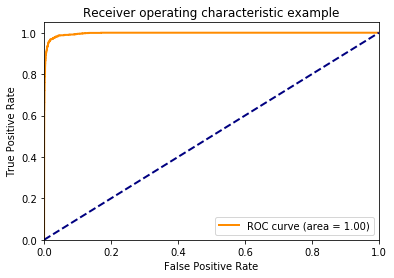

In [6]:
tf.reset_default_graph()
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, num_classes)
(fpr, tpr, roc_auc, pred) = mnist.run(mnistCont.withRandomContingency, learning_rate, mnistCont, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

In [52]:
np.where(mnist.test.labels >= num_classes)

(array([   0,    7,    8, ..., 9992, 9998, 9999]),)

In [5]:
mnist.test.images[:]

array([], shape=(0, 784), dtype=float32)